In [1]:
# https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710
import cv2
import imutils
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import os.path
import glob
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import pickle
import tensorflow
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense

Using TensorFlow backend.


In [2]:
# https://github.com/BenjaminWegener/CaptchaSolver
def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    :param image: image to resize
    :param width: desired width in pixels
    :param height: desired height in pixels
    :return: the resized image
    """

    # grab the dimensions of the image, then initialize
    # the padding values
    (h, w) = image.shape[:2]

    # if the width is greater than the height then resize along
    # the width
    if w > h:
        image = imutils.resize(image, width=width)

    # otherwise, the height is greater than the width so resize
    # along the height
    else:
        image = imutils.resize(image, height=height)

    # determine the padding values for the width and height to
    # obtain the target dimensions
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)

    # pad the image then apply one more resizing to handle any
    # rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

    # return the pre-processed image
    return image

# Processamento do captcha

## Qualidade da imagem

In [3]:
def processImage(img):    
    imgBorder = cv2.copyMakeBorder(img, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    ret, imgThreshold = cv2.threshold(imgBorder, 127, 255, cv2.THRESH_BINARY)

#     plt.imshow(imgThreshold, cmap='gray')
#     plt.axis('off')
#     plt.show()
    
    kernel = np.ones((1,2), np.uint8)
    imgErode = cv2.erode(imgThreshold, kernel, iterations = 1)

#     plt.imshow(imgErode, cmap='gray')
#     plt.axis('off')
#     plt.show()
    
    return imgErode


In [30]:
img = cv2.imread("tests/01.png", 0)

imgErode = processImage(img)

## Encontrando letras

In [5]:
def findLetters(imgErode):
    contours = cv2.findContours(imgErode, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    contours = contours[0]
    imageRegions = []
    areaArr = []

    for contour in contours:
        area = cv2.contourArea(contour)
        areaArr.append(area)
    
    # encontrando mediana para descartar áreas fora do padrão
    median = 0
    areaArr.sort()
    if len(areaArr)%2 != 0:
        mid = int(len(areaArr)/2)
        median = areaArr[mid]
    else:
        mid = int(len(areaArr)/2)
        median = (areaArr[mid] + areaArr[mid - 1])/2
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 3*median or area < median/3:
            continue;

        x, y, w, h = cv2.boundingRect(contour)
        imgRGB = cv2.cvtColor(imgErode,cv2.COLOR_GRAY2RGB)
    
        # se duas letras estiverem juntas
        if w/h > 1.25:
            half_width = int(w/2)
            imageRegions.append((x, y, half_width, h))
            imageRegions.append((x + half_width, y, half_width, h))
        else:
            imageRegions.append((x, y, w, h))
    
    imageRegions = sorted(imageRegions, key=lambda x: x[0])
    
    return imageRegions


In [6]:
def printRegions(imageRegions):
    for point in imageRegions:    
        imgRGB = cv2.cvtColor(imgErode, cv2.COLOR_GRAY2RGB)
        imgRect = cv2.rectangle(imgRGB, (point[0], point[1]), (point[0]+point[2], point[1]+point[3]), (255,0,0), 1)

        plt.imshow(imgRect)
        plt.axis('off')
        plt.show()

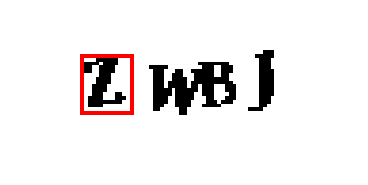

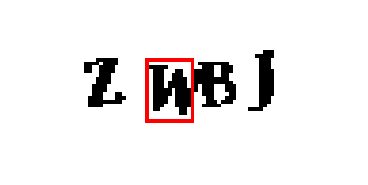

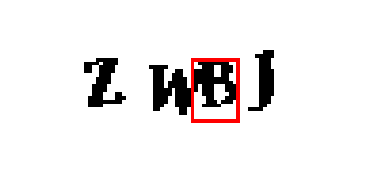

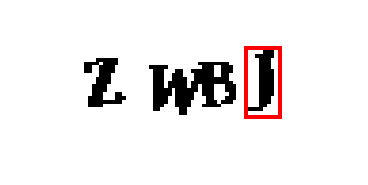

In [7]:
imageRegions = findLetters(imgErode)
printRegions(imageRegions)

## Rodando processamento nos dados

In [8]:
FOLDER_INPUT = "data"
FOLDER_OUTPUT = "data_letters"
captchaImgs = glob.glob(os.path.join(FOLDER_INPUT, "*"))
countLetter = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
countNumber = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i, file in enumerate(captchaImgs):
    name = os.path.basename(file)
    captchaText = os.path.splitext(name)[0] # pegando só texto (sem ".png")
    pathImg = "data/" + name
#    print("Processando", i, "de", len(captchaImgs), "-", pathImg)
    
    img = cv2.imread(pathImg, 0)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
#     plt.show()
    
    imgErode = processImage(img)
    
    imageRegions = findLetters(imgErode)
#     printRegions(imageRegions)
    if len(imageRegions) != 4:
        continue;
        
    for points, letter in zip(imageRegions, captchaText):
        x, y, w, h = points
        
        imageSave = imgErode[y:y + h, x:x + w]
        
#         plt.imshow(imageSave)
#         plt.axis('off')
#         plt.show()
        
        pathSave = os.path.join(FOLDER_OUTPUT, letter)
    
        if not os.path.exists(pathSave):
            os.makedirs(pathSave)
        
        ans = ord(letter)

        if ans >= 0 and ans < ord('A'):
            idx = ans - ord('0')
            countNumber[idx] = countNumber[idx] + 1
            strImgPath = str(countNumber[idx]) + ".png"
        else:
            idx = ans - ord('A')
            countLetter[idx] = countLetter[idx] + 1
            strImgPath = str(countLetter[idx]) + ".png"
        
#         print(strImgPath)
        pt = os.path.join(pathSave, strImgPath)
        cv2.imwrite(pt, imageSave)

print("finish processing")

finish processing


# Machine Learning

## Treinando modelo

In [9]:
FOLDER_LETTERS_INPUT = "data_letters"

dataImages = []
dataLabels = []

for file in paths.list_images(FOLDER_LETTERS_INPUT):
    image = cv2.imread(file, 0)
    image = resize_to_fit(image, 20, 20)
    image = np.expand_dims(image, axis=2)

    label = file.split(os.path.sep)[-2]
    
#    print("append data...")
    dataImages.append(image)
    dataLabels.append(label)

print("finish append")


finish append


In [10]:
print(len(dataImages))
print(len(dataLabels))

34832
34832


In [11]:
FILE_LABELS_MODEL = "label_model.dat"

dataImages = np.array(dataImages)/255
dataLabels = np.array(dataLabels)

encoder = LabelBinarizer()
dataLabels = encoder.fit_transform(dataLabels)

(Xtrain, Xtest, Ytrain, Ytest) = train_test_split(dataImages, dataLabels, test_size=0.25, random_state=70)

with open(FILE_LABELS_MODEL, "wb") as f:
    pickle.dump(encoder, f)


In [12]:
MODEL_FILE = "model.hdf5"

model = Sequential()

model.add(Conv2D(20, (2, 2), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64, (2, 2), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128, (2, 2), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(256, (2, 2), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(500, activation="relu"))

model.add(Dense(32, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adagrad", metrics=["accuracy"])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 20)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        5184      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 128)         32896     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
conv

In [13]:
model.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest), batch_size=32, epochs=10, verbose=1)
model.save(MODEL_FILE)

Instructions for updating:
Use tf.cast instead.
Train on 26124 samples, validate on 8708 samples
Epoch 1/10
26124/26124 [==============================] - 10s 387us/step - loss: 0.4556 - acc: 0.8725 - val_loss: 0.0642 - val_acc: 0.9892
Epoch 2/10
26124/26124 [==============================] - 10s 367us/step - loss: 0.0478 - acc: 0.9909 - val_loss: 0.0412 - val_acc: 0.9929
Epoch 3/10
26124/26124 [==============================] - 9s 341us/step - loss: 0.0312 - acc: 0.9938 - val_loss: 0.0357 - val_acc: 0.9939
Epoch 4/10
26124/26124 [==============================] - 9s 346us/step - loss: 0.0234 - acc: 0.9954 - val_loss: 0.0308 - val_acc: 0.9947
Epoch 5/10
26124/26124 [==============================] - 9s 345us/step - loss: 0.0182 - acc: 0.9966 - val_loss: 0.0298 - val_acc: 0.9948
Epoch 6/10
26124/26124 [==============================] - 10s 370us/step - loss: 0.0149 - acc: 0.9971 - val_loss: 0.0296 - val_acc: 0.9952
Epoch 7/10
26124/26124 [==============================] - 9s 352us/step 

### Testando com captcha

In [24]:
def predictImage(img):
    dataImagesPredict = []

    imgErode = processImage(img)
    imageRegions = findLetters(imgErode)

    for points in imageRegions:
        x, y, w, h = points

        image = imgErode[y:y + h, x:x + w]

        image = resize_to_fit(image, 20, 20)
        image = np.expand_dims(image, axis=2)

        dataImagesPredict.append(image)

    dataImagesPredict = np.array(dataImagesPredict)/255

    for element in dataImagesPredict:
        prediction = model.predict(dataImagesPredict)
        letter = encoder.inverse_transform(prediction)

    print("CAPTCHA TEXT:", letter)
    plt.imshow(imgErode, cmap='gray')
    plt.axis('off')
    plt.show()


CAPTCHA TEXT: ['Z' 'W' 'B' 'J']


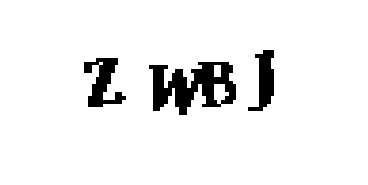

CAPTCHA TEXT: ['C' 'G' 'L' 'T']


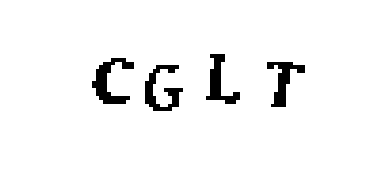

In [31]:
img = cv2.imread("tests/01.png", 0)
predictImage(img)

img = cv2.imread("tests/02.png", 0)
predictImage(img)